In [1]:
# https://github.com/Suzehva/time_in_language_models_current/blob/main/ii_accuracy/ii_accuracy.py

In [2]:
import numpy as np
import random
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Create all prompts where interchanging should cause the model to switch tenses (past/present/future)

In [3]:
# from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

model_id = "EleutherAI/pythia-1.4b-deduped-v0"
revision = None

USER = 'aditijb'

DATA_DIR = f'/nlp/scr/{USER}/data'
MODEL_DIR = f'/nlp/scr/{USER}/models'


## Heatmap with one prompt
    

In [4]:
import pandas as pd
import pyvene
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import RepresentationConfig, IntervenableConfig, IntervenableModel
from pyvene import VanillaIntervention

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

 
config, tokenizer, pythia = pyvene.create_gpt_neox(name="EleutherAI/pythia-1.4b-deduped-v0")
# TODO FIGURE THIS OUT!! asked jing if this was correct... I'll see...

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.
loaded model


In [6]:
print("pythia.config.num_hidden_layers", pythia.config.num_hidden_layers)

pythia.config.num_hidden_layers 24


In [ ]:

def simple_position_config(model_type, component, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                component,          # component
                "pos",              # intervention unit
                1,                  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config

base = tokenizer("In 1981 there", return_tensors="pt")
sources = [tokenizer("In 2023 there", return_tensors="pt")]
tokens = tokenizer.encode(" was will")
data = []



# Added by aditi to print next token gen.
import torch

def print_topk_next_tokens(logits, tokenizer, layer_i, k=5):
    # take only last position (true next-token distribution)
    distrib = torch.softmax(logits, dim=-1)[0, -1]
    topk_probs, topk_ids = torch.topk(distrib, k)

    decoded = [format_token(tokenizer, tid.item()) for tid in topk_ids]
    print(f"[Layer {layer_i}, Final Position]")
    print("Top-k next tokens:", list(zip(decoded, topk_probs.tolist())))
    print()



# do intervention gathering of hidden layers :)

for layer_i in range(pythia.config.num_hidden_layers):
    config = simple_position_config(type(pythia), "block_output", layer_i) # TODO don't use MLP
    intervenable = IntervenableModel(config, pythia)
    for pos_i in range(len(base.input_ids[0])):
        
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        logits = counterfactual_outputs.logits
        distrib = torch.softmax(logits, dim=-1)
        intervention_token_id = base.input_ids[0][pos_i].item()
        intervention_token = format_token(tokenizer, intervention_token_id)
        

        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"f{layer_i}",
                    "pos": pos_i,
                    "intervention_token": intervention_token,  # Added this line
                    "type": "block_output",
                }
            )

df = pd.DataFrame(data)



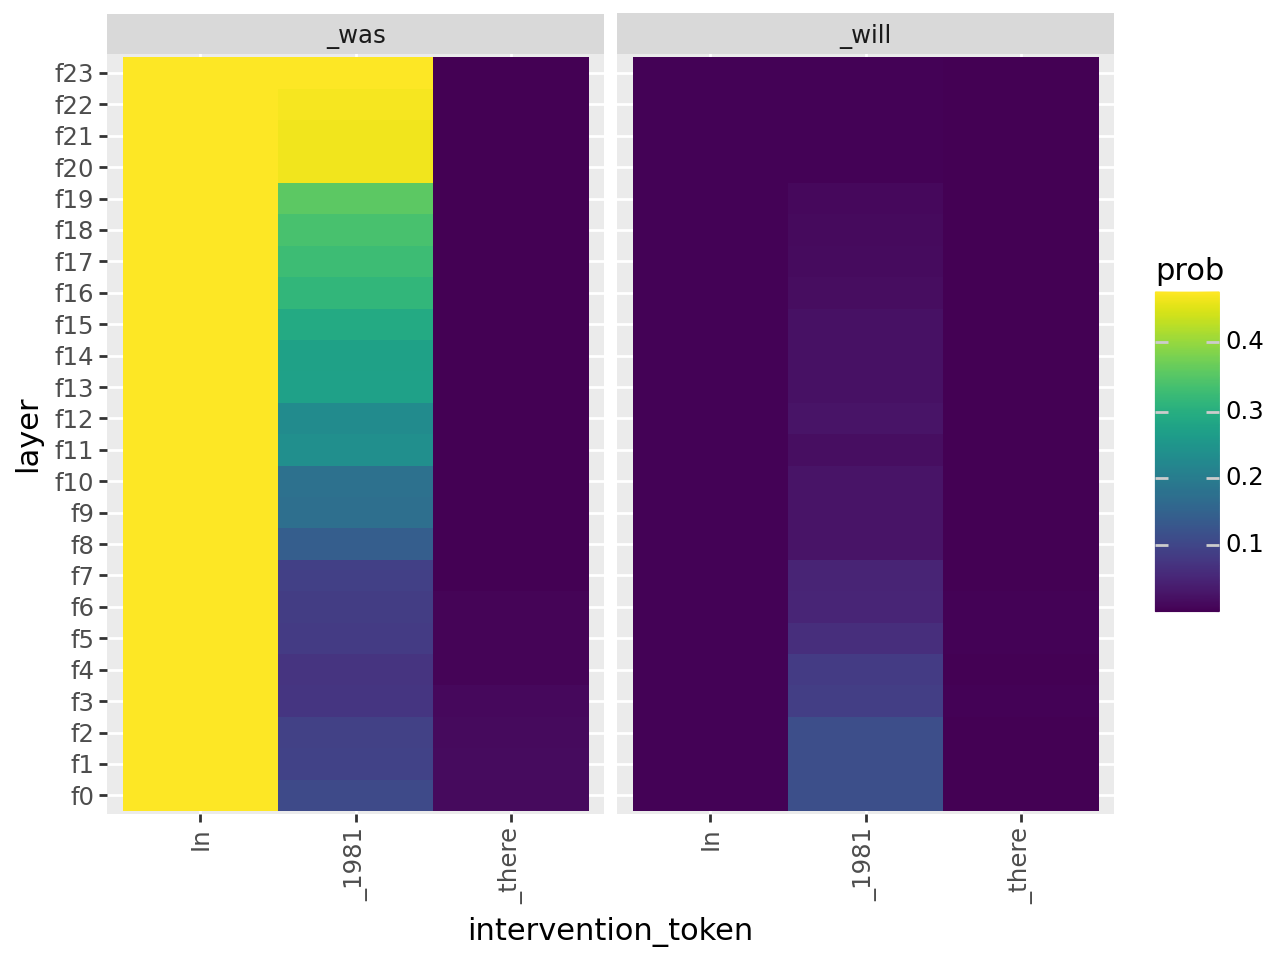

In [8]:
import torch
from plotnine import options

df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")

# layers with 0 at bottom, 15 at top
layer_nodes = [f"f{l}" for l in range(pythia.config.num_hidden_layers)]
df["layer"] = pd.Categorical(df["layer"], categories=layer_nodes, ordered=True)

# Order intervention tokens by their position in the sentence
intervention_token_order = []
for pos_i in range(len(base.input_ids[0])):
    intervention_token_id = base.input_ids[0][pos_i].item()
    intervention_token = format_token(tokenizer, intervention_token_id)
    intervention_token_order.append(intervention_token)

df["intervention_token"] = pd.Categorical(
    df["intervention_token"],
    categories=intervention_token_order,
    ordered=True
)

g = (
    ggplot(df)
    + geom_tile(aes(x="intervention_token", y="layer", fill="prob"), raster=False)
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)

options.figure_size = (8, 6)  # optional
g
